In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from scipy import stats as sc
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
import pickle
import seaborn as sns
from numpy import log
from sklearn.feature_selection import RFECV
from random import randrange, choices

Using TensorFlow backend.


In [27]:
plt.rcParams.update({'font.size': 22})

In [15]:
class SFS():
    def __init__(self, estimator, k_features, metric="accuracy", test_size=0.25, cv=5, classification = True, random_state=1):
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.cv = cv
        self.metric = metric
        self.classification = classification
        self.random_state = random_state
    def fit(self, X, y):   
        if self.metric == "bic":
            calc_score = self._bic_calc_score
        elif self.metric == "cv":
            calc_score = self._cv_calc_score
        else:
            calc_score = self._accuracy_calc_score
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = 0
        options = list(range(X_train.shape[1]))
        self.indices_ = []
        self.subsets_ = []
        self.scores_ = []
        self.test_scores_ = []
        while dim < self.k_features:
            print('Processing:', dim)
            scores, subsets, test_scores = [], [], []
            comb=[]
            for opt in options:
                comb.append(self.indices_+[opt])
#             print(comb)
            for p in comb:
                score = calc_score(X_train, y_train, X_test, y_test, p)
                test_score = self._accuracy_calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                test_scores.append(test_score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            options.remove(subsets[best][-1])
            self.subsets_.append(self.indices_)
            dim += 1
            self.scores_.append(scores[best])
            self.test_scores_.append(test_scores[best])
        self.k_score_ = self.scores_[-1]
        self.subsets_ = [tuple(x) for x in self.subsets_]
        return self
    def transform(self, X):
        return X[:, self.indices_]
    def _accuracy_calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = accuracy_score(y_test, y_pred)
        return score
    def _cv_calc_score(self, X_train, y_train, X_test, y_test, indices):
        cv_scores = cross_val_score(self.estimator, X_train[:, indices], y_train, cv=self.cv, n_jobs=-1)
        score = np.mean(cv_scores)
        return score
    def _bic_calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        if self.classification:
            sse = np.sum(y_pred != y_test)
        else:
            sse = sum((y_test - y_pred)**2)
        n = len(X_test)
        k = len(indices)
        bic = n*log(sse/n) + k*log(n)
        return -(bic)
    

def plotSFS(sfs):
    k_feat = [len(k) for k in sfs.subsets_]
    plt.figure(1, (9,6))
    plt.plot(k_feat, sfs.test_scores_, marker='o', color='orange', label = 'Test set score')
    if sfs.metric == 'cv':
        plt.plot(k_feat, sfs.scores_, marker='o', color='deepskyblue', label = str(sfs.cv) + '-fold CV score')
    plt.ylim([0.0, 1.02])
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    plt.grid()
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()
    for idx, subs in enumerate(sfs.subsets_):
        print(str(len(subs))+' feature(s):', sorted(subs), ' Metric Score:', sfs.scores_[idx], ' Test Score:', sfs.test_scores_[idx])

In [31]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)
    
def rfFeaturePlot(rf_reg, col_list, plot=True, title="Feature importances"):
    importances = rf_reg.feature_importances_

    std = np.std([tree.feature_importances_ for tree in rf_reg.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    if plot:
        # Plot the feature importances of the forest
        plt.figure(1,(12,9))
        plt.title(title)
        plt.bar(range(rf_reg.n_features_), importances[indices],  
               color="r", align="center")
        plt.xticks(range(rf_reg.n_features_),col_list[indices],  fontsize=15)
#         plt.xlim([-1,rf_reg.n_features_)
        plt.xlim([-1,4])
        plt.ylabel('Relative Importance')
        plt.show()
        
def variance_threshold_selector(data, threshold=0.7):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def kBestSelector(data, y, score_func = chi2, k = 5):
    selector = SelectKBest(score_func, k = k).fit(data, y)
    return data[data.columns[selector.get_support(indices=True)]]

def plotPca(pca, Xtrain):
    plt.figure(1,(8,6))
    plt.bar(range(1, Xtrain.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, Xtrain.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xlim([0, 300])
    plt.show()
    
def get_important_features(transformed_features, components_, columns):
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])
    
    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by importance:\n", important_features)
def cvKBestSelector(X, y, model, scaler = None, testSize = 0.25, cv = 5, random_state = 20191027):
    result_dict = {}
    for k_v in range(1, X.shape[1]+1):
        X_ked = kBestSelector(X, y, score_func = chi2, k = k_v)
        X_train, X_test, y_train, y_test = train_test_split(X_ked, y, test_size=testSize, random_state=random_state)
        if scaler != None:
            scaler = scaler
            X_train = scaler.fit_transform(X_train.values)
            X_test = scaler.transform(X_test.values)
        else:
            X_train, X_test = X_train.values, X_test.values
        loc_model = clone(model)
        loc_model.fit(X_train, y_train)
        cv_scores = cross_val_score(loc_model, X_train, y_train, cv=cv, n_jobs=-1)
        result_dict[k_v] = (cv_scores, loc_model.score(X_train, y_train), np.mean(cv_scores), loc_model.score(X_test, y_test))
    max = float("-inf")
    fn = 0
    for k,v in result_dict.items():
        if v[2] > max:
            fn = k
            max = v[2]
    print(fn, max)

    x_ax = []
    y_ax = []
    test_pred = []
    train_pred = []
    for k,v in result_dict.items():
        x_ax.append(k)
        train_pred.append(v[1])
        y_ax.append(v[2])
        test_pred.append(v[3])
    plt.figure(figsize=(12,9))
    plt.title('Score against number of features')
    plt.ylabel('Accuracy')
    plt.xlabel('n features')
    plt.plot(x_ax, y_ax, color='orange', label = str(cv) + '-fold CV score')
    plt.plot(x_ax, test_pred, color='deepskyblue', label = 'Testing score')
    plt.plot(x_ax, train_pred, color='red', label = 'Training score')
    plt.legend(loc='best')
    plt.show()
    return fn

def cvPCA(X, y, model, testSize = 0.25, cv = 5, random_state = 20191027):
    result_dict = {}
    for k_v in range(1, X.shape[1]+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=random_state)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train.values)
        X_test = scaler.transform(X_test.values)
        pca = PCA(n_components = k_v)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        loc_model = clone(model)
        loc_model.fit(X_train, y_train)
        cv_scores = cross_val_score(loc_model, X_train, y_train, cv=cv, n_jobs=-1)
        result_dict[k_v] = (cv_scores, loc_model.score(X_train, y_train), np.mean(cv_scores), loc_model.score(X_test, y_test))
    max = float("-inf")
    fn = 0
    for k,v in result_dict.items():
        if v[2] > max:
            fn = k
            max = v[2]
    print(fn, max)

    x_ax = []
    y_ax = []
    test_pred = []
    train_pred = []
    for k,v in result_dict.items():
        x_ax.append(k)
        train_pred.append(v[1])
        y_ax.append(v[2])
        test_pred.append(v[3])
    plt.figure(figsize=(12,9))
    plt.title('Score against number of principal components')
    plt.ylabel('Accuracy')
    plt.xlabel('n PCA components')
    plt.plot(x_ax, y_ax, color='orange', label = str(cv) + '-fold CV score')
    plt.plot(x_ax, test_pred, color='deepskyblue', label = 'Testing score')
    plt.plot(x_ax, train_pred, color='red', label = 'Training score')
    plt.legend(loc='best')
    plt.show()
    return fn

In [17]:
def variance_threshold_selector(data, threshold=0.7):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def kBestSelector(data, y, score_func = chi2, k = 5):
    selector = SelectKBest(score_func, k = k).fit(data, y)
    return data[data.columns[selector.get_support(indices=True)]]


In [11]:
suffix = ""

In [12]:
complete_season_path = "master_data_ver2/all_season_master_data_each_player_goals.csv"
complete_season_df = pd.read_csv(complete_season_path)

In [13]:
allCols = complete_season_df.columns
player_col = []
for col in allCols:
    if col.startswith("home_player") or col.startswith("away_player"):
        player_col.append(col)

In [14]:
player_col

['home_player_1_match_goal',
 'home_player_2_match_goal',
 'home_player_3_match_goal',
 'home_player_4_match_goal',
 'home_player_5_match_goal',
 'home_player_6_match_goal',
 'home_player_7_match_goal',
 'home_player_8_match_goal',
 'home_player_9_match_goal',
 'home_player_10_match_goal',
 'home_player_11_match_goal',
 'away_player_1_match_goal',
 'away_player_2_match_goal',
 'away_player_3_match_goal',
 'away_player_4_match_goal',
 'away_player_5_match_goal',
 'away_player_6_match_goal',
 'away_player_7_match_goal',
 'away_player_8_match_goal',
 'away_player_9_match_goal',
 'away_player_10_match_goal',
 'away_player_11_match_goal',
 'home_player_1_fpl_minutes',
 'home_player_1_fpl_goals',
 'home_player_1_fpl_assits',
 'home_player_1_fpl_cs',
 'home_player_1_fpl_points',
 'home_player_1_fpl_bonus',
 'home_player_1_fpl_cprice',
 'home_player_1_player_rating',
 'home_player_1_touches',
 'home_player_1_saves',
 'home_player_1_total_pass',
 'home_player_1_aerial_won',
 'home_player_1_form

In [15]:
player_stat_col = []
for col in player_col:
    if not col.endswith("match_goal"):
        splitted = col.split('_')
        stat = '_'.join(splitted[3:])
        if stat not in player_stat_col:
            player_stat_col.append(stat)

In [16]:
player_stat_col

['fpl_minutes',
 'fpl_goals',
 'fpl_assits',
 'fpl_cs',
 'fpl_points',
 'fpl_bonus',
 'fpl_cprice',
 'player_rating',
 'touches',
 'saves',
 'total_pass',
 'aerial_won',
 'formation_place',
 'accurate_pass',
 'total_tackle',
 'aerial_lost',
 'fouls',
 'yellow_card',
 'total_scoring_att',
 'man_of_the_match',
 'goals',
 'won_contest',
 'blocked_scoring_att',
 'goal_assist',
 'good_high_claim',
 'second_yellow',
 'red_card',
 'error_lead_to_goal',
 'last_man_tackle',
 'six_yard_block',
 'post_scoring_att',
 'att_pen_target',
 'penalty_save',
 'penalty_conceded',
 'clearance_off_line',
 'att_pen_goal',
 'att_pen_miss',
 'own_goals',
 'att_pen_post']

In [17]:
complete_season_df = complete_season_df[['match_id'] + player_col]                             

In [18]:
complete_season_df

,match_id,home_player_1_match_goal,home_player_2_match_goal,home_player_3_match_goal,home_player_4_match_goal,home_player_5_match_goal,home_player_6_match_goal,home_player_7_match_goal,home_player_8_match_goal,home_player_9_match_goal,...,away_player_11_six_yard_block,away_player_11_post_scoring_att,away_player_11_att_pen_target,away_player_11_penalty_save,away_player_11_penalty_conceded,away_player_11_clearance_off_line,away_player_11_att_pen_goal,away_player_11_att_pen_miss,away_player_11_own_goals,away_player_11_att_pen_post
0,829513,0,0,0,0,1,0,0,0,1,...,1.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,829514,0,0,0,0,0,1,0,0,0,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,829515,0,0,0,0,0,0,0,0,0,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,829516,0,0,0,0,0,0,0,0,1,...,0.00000,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,829517,0,0,0,0,0,0,0,0,1,...,1.00000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,829518,0,0,0,0,0,0,0,0,0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,829519,0,0,0,0,0,0,0,0,0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,829520,0,0,0,0,0,0,0,0,0,...,1.00000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,829521,0,0,0,0,0,0,0,0,0,...,0.00000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,829522,0,0,0,0,0,0,0,0,0,...,1.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# df_cols = ['match_id', 'scored'] + player_stat_col
# goaler_df = pd.DataFrame(columns=df_cols)
# index = 0
# for _, row in complete_season_df.iterrows():
#     match_id = int(row['match_id'])
#     homeScorer, awayScorer = [], []
#     homeNormies, awayNormies = [], []
#     for i in range(1,12):
#         home_match_goal_col = "home_player_"+str(i)+"_match_goal"
#         away_match_goal_col = "away_player_"+str(i)+"_match_goal"
#         if row[home_match_goal_col] >= 1:
#             homeScorer.append(i)
#         if row[away_match_goal_col] >= 1:
#             awayScorer.append(i)
            
#     for scorer in homeScorer:
#         newScorerRow = []
#         newScorerRow.append(match_id)
#         newScorerRow.append(int(1))
#         for stat in player_stat_col:
#             colName = 'home_player_' + str(scorer) + "_" + stat
#             newScorerRow.append(float(row[colName]))
#         goaler_df.loc[index] = newScorerRow
#         index += 1
        
#         newPlebsRow = []
#         newPlebsRow.append(match_id)
#         newPlebsRow.append(int(0))
#         tryAgain = True
#         while tryAgain:
#             plebNumber = randrange(1,12)
#             if (plebNumber not in awayScorer) and (plebNumber not in awayNormies):
#                 tryAgain = False
#                 awayNormies.append(plebNumber)
        
#         for stat in player_stat_col:
#             colName = 'away_player_' + str(plebNumber) + "_" + stat
#             newPlebsRow.append(float(row[colName]))
#         goaler_df.loc[index] = newPlebsRow
#         index += 1
    
#     for scorer in awayScorer:
#         newScorerRow = []
#         newScorerRow.append(match_id)
#         newScorerRow.append(int(1))
#         for stat in player_stat_col:
#             colName = 'away_player_' + str(scorer) + "_" + stat
#             newScorerRow.append(float(row[colName]))
#         goaler_df.loc[index] = newScorerRow
#         index += 1
        
#         newPlebsRow = []
#         newPlebsRow.append(match_id)
#         newPlebsRow.append(int(0))
#         tryAgain = True
#         while tryAgain:
#             plebNumber = randrange(1,12)
#             if (plebNumber not in homeScorer) and (plebNumber not in homeNormies):
#                 tryAgain = False
#                 homeNormies.append(plebNumber)
        
#         for stat in player_stat_col:
#             colName = 'home_player_' + str(plebNumber) + "_" + stat
#             newPlebsRow.append(float(row[colName]))
#         goaler_df.loc[index] = newPlebsRow
#         index += 1
# goaler_df.to_csv ("master_data_ver2/goal_prediction" + suffix + ".csv", index = None, header=True)       

In [16]:
# df_cols = ['match_id', 'scored'] + player_stat_col
# goaler_df = pd.DataFrame(columns=df_cols)
# index = 0
# for _, row in complete_season_df.iterrows():
#     match_id = int(row['match_id'])
#     homeScorer, awayScorer = [], []
#     homeNormies, awayNormies = [], []
#     for i in range(1,12):
#         home_match_goal_col = "home_player_"+str(i)+"_match_goal"
#         away_match_goal_col = "away_player_"+str(i)+"_match_goal"
#         if row[home_match_goal_col] >= 1:
#             homeScorer.append(i)
#         if row[away_match_goal_col] >= 1:
#             awayScorer.append(i)
            
#     for player in range(1,12):
#         home_match_goal_col = "home_player_"+str(player)+"_match_goal"
#         scored = 0
#         if row[home_match_goal_col] >= 1:
#             scored = 1
#         newPlayerRow = []
#         newPlayerRow.append(match_id)
#         newPlayerRow.append(scored)
#         for stat in player_stat_col:
#             colName = 'home_player_' + str(player) + "_" + stat
#             newPlayerRow.append(float(row[colName]))
#         goaler_df.loc[index] = newPlayerRow
#         index += 1
    
#     for player in range(1,12):
#         away_match_goal_col = "away_player_"+str(player)+"_match_goal"
#         scored = 0
#         if row[away_match_goal_col] >= 1:
#             scored = 1
#         newPlayerRow = []
#         newPlayerRow.append(match_id)
#         newPlayerRow.append(scored)
#         for stat in player_stat_col:
#             colName = 'away_player_' + str(player) + "_" + stat
#             newPlayerRow.append(float(row[colName]))
#         goaler_df.loc[index] = newPlayerRow
#         index += 1
        
# goaler_df.to_csv ("master_data_ver2/all_player_goals_unbalanced.csv", index = None, header=True)      

In [21]:
df_cols = ['match_id', 'scored'] + player_stat_col
goaler_df = pd.DataFrame(columns=df_cols)
index = 0
for _, row in complete_season_df.iterrows():
    match_id = int(row['match_id'])
    homeScorer, awayScorer = [], []
    
    for i in range(1,12):
        home_match_goal_col = "home_player_"+str(i)+"_match_goal"
        away_match_goal_col = "away_player_"+str(i)+"_match_goal"
        if row[home_match_goal_col] >= 1:
            homeScorer.append(i)
        if row[away_match_goal_col] >= 1:
            awayScorer.append(i)
            
    for player in range(1,12):
        home_match_goal_col = "home_player_"+str(player)+"_match_goal"
        scored = 0
        if row[home_match_goal_col] >= 1:
            scored = int(row[home_match_goal_col])
        newPlayerRow = []
        newPlayerRow.append(match_id)
        newPlayerRow.append(scored)
        for stat in player_stat_col:
            colName = 'home_player_' + str(player) + "_" + stat
            newPlayerRow.append(float(row[colName]))
        goaler_df.loc[index] = newPlayerRow
        index += 1
    
    for player in range(1,12):
        away_match_goal_col = "away_player_"+str(player)+"_match_goal"
        scored = 0
        if row[away_match_goal_col] >= 1:
            scored = int(row[home_match_goal_col])
        newPlayerRow = []
        newPlayerRow.append(match_id)
        newPlayerRow.append(scored)
        for stat in player_stat_col:
            colName = 'away_player_' + str(player) + "_" + stat
            newPlayerRow.append(float(row[colName]))
        goaler_df.loc[index] = newPlayerRow
        index += 1
        
goaler_df.to_csv ("master_data_ver2/all_player_goals_number_unbalanced.csv", index = None, header=True)      

In [47]:
df_cols = ['match_id', 'scored'] + player_stat_col
goaler_df = pd.DataFrame(columns=df_cols)
index = 0
k=400
players_goal_dict = {}
for _, row in complete_season_df.iterrows():
    match_id = int(row['match_id'])
    homeScorer, awayScorer = [], []
    homeNormies, awayNormies = [], []
    for i in range(1,12):
        home_match_goal_col = "home_player_"+str(i)+"_match_goal"
        away_match_goal_col = "away_player_"+str(i)+"_match_goal"
        if row[home_match_goal_col] >= 1:
            if row[home_match_goal_col] not in players_goal_dict:
                players_goal_dict[row[home_match_goal_col]] = []
            homeScorer.append((i, row[home_match_goal_col]))
        if row[away_match_goal_col] >= 1:
            if row[away_match_goal_col] not in players_goal_dict:
                players_goal_dict[row[away_match_goal_col]] = []
            awayScorer.append((i, row[away_match_goal_col]))
            
    for scorer, goal in homeScorer:
        newScorerRow = []
        newScorerRow.append(match_id)
        newScorerRow.append(int(goal))
        for stat in player_stat_col:
            colName = 'home_player_' + str(scorer) + "_" + stat
            newScorerRow.append(float(row[colName]))
        players_goal_dict[goal].append(newScorerRow)
        
    for scorer, goal in awayScorer:
        newScorerRow = []
        newScorerRow.append(match_id)
        newScorerRow.append(int(goal))
        for stat in player_stat_col:
            colName = 'away_player_' + str(scorer) + "_" + stat
            newScorerRow.append(float(row[colName]))
        players_goal_dict[goal].append(newScorerRow)
        
for i in range(1,4):
    choices_list = choices(players_goal_dict[i], k=k)
    for choice in choices_list:
        goaler_df.loc[index] = choice
        index += 1
#         newPlebsRow = []
#         newPlebsRow.append(match_id)
#         newPlebsRow.append(int(0))
#         tryAgain = True
#         while tryAgain:
#             plebNumber = randrange(1,12)
#             if (plebNumber not in homeScorer) and (plebNumber not in homeNormies):
#                 tryAgain = False
#                 homeNormies.append(plebNumber)
        
#         for stat in player_stat_col:
#             colName = 'home_player_' + str(plebNumber) + "_" + stat
#             newPlebsRow.append(float(row[colName]))
#         goaler_df.loc[index] = newPlebsRow
#         index += 1
goaler_df.to_csv ("master_data_ver2/goal_prediction_numeric" + suffix + ".csv", index = None, header=True)       

In [27]:
df_cols = ['match_id', 'scored'] + player_stat_col
goaler_df = pd.DataFrame(columns=df_cols)
index = 0
players_goal_dict = {}
for _, row in complete_season_df.iterrows():
    match_id = int(row['match_id'])
    homeScorer, awayScorer = [], []
    homeNormies, awayNormies = [], []
    for i in range(1,12):
        home_match_goal_col = "home_player_"+str(i)+"_match_goal"
        away_match_goal_col = "away_player_"+str(i)+"_match_goal"
        if row[home_match_goal_col] >= 1:
            if row[home_match_goal_col] not in players_goal_dict:
                players_goal_dict[row[home_match_goal_col]] = []
            players_goal_dict[row[home_match_goal_col]].append((match_id, 'home', i))
        if row[away_match_goal_col] >= 1:
            if row[away_match_goal_col] not in players_goal_dict:
                players_goal_dict[row[away_match_goal_col]] = []
            players_goal_dict[row[away_match_goal_col]].append((match_id, 'away', i))

# all player goal distribution

In [22]:
all_goals_path = "master_data_ver2/all_player_goals_number_unbalanced.csv"
all_goals_df = pd.read_csv(all_goals_path)
all_goals_df

,match_id,scored,fpl_minutes,fpl_goals,fpl_assits,fpl_cs,fpl_points,fpl_bonus,fpl_cprice,player_rating,...,six_yard_block,post_scoring_att,att_pen_target,penalty_save,penalty_conceded,clearance_off_line,att_pen_goal,att_pen_miss,own_goals,att_pen_post
0,829513.0,0.0,1498.00000,0.00000,0.00000,3.00000,47.00000,0.00000,5.200000,3.228529,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,829513.0,0.0,1572.00000,1.00000,1.00000,7.00000,68.00000,8.00000,4.500000,6.204231,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,829513.0,0.0,805.00000,1.00000,1.00000,0.00000,23.00000,0.00000,5.200000,6.580909,...,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,829513.0,0.0,1660.00000,0.00000,5.00000,6.00000,76.00000,9.00000,5.200000,4.438571,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,829513.0,1.0,2287.00000,3.00000,0.00000,11.00000,120.00000,15.00000,6.100000,6.651000,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,829513.0,0.0,447.00000,0.00000,1.00000,3.00000,19.00000,2.00000,5.200000,5.888750,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,829513.0,0.0,2990.00000,7.00000,11.00000,12.00000,168.00000,23.00000,8.400000,7.401579,...,1.5,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,829513.0,0.0,2944.00000,16.00000,8.00000,12.00000,207.00000,29.00000,11.600000,7.590833,...,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,829513.0,1.0,2007.00000,6.00000,6.00000,10.00000,116.00000,13.00000,8.800000,6.839000,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,829513.0,0.0,729.00000,2.00000,1.00000,1.00000,36.00000,4.00000,6.300000,5.634706,...,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


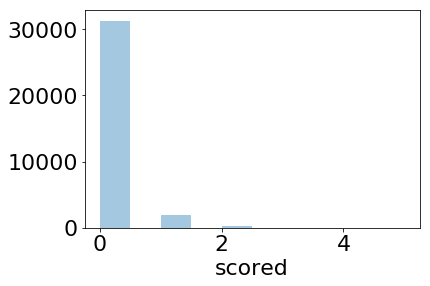

In [29]:
sns.distplot(all_goals_df['scored'], bins = 10, kde = False)

In [31]:
all_goals_df[all_goals_df['scored'] == 0]

,match_id,scored,fpl_minutes,fpl_goals,fpl_assits,fpl_cs,fpl_points,fpl_bonus,fpl_cprice,player_rating,...,six_yard_block,post_scoring_att,att_pen_target,penalty_save,penalty_conceded,clearance_off_line,att_pen_goal,att_pen_miss,own_goals,att_pen_post
0,829513.0,0.0,1498.00000,0.00000,0.00000,3.00000,47.00000,0.00000,5.200000,3.228529,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,829513.0,0.0,1572.00000,1.00000,1.00000,7.00000,68.00000,8.00000,4.500000,6.204231,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,829513.0,0.0,805.00000,1.00000,1.00000,0.00000,23.00000,0.00000,5.200000,6.580909,...,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,829513.0,0.0,1660.00000,0.00000,5.00000,6.00000,76.00000,9.00000,5.200000,4.438571,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,829513.0,0.0,447.00000,0.00000,1.00000,3.00000,19.00000,2.00000,5.200000,5.888750,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,829513.0,0.0,2990.00000,7.00000,11.00000,12.00000,168.00000,23.00000,8.400000,7.401579,...,1.5,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,829513.0,0.0,2944.00000,16.00000,8.00000,12.00000,207.00000,29.00000,11.600000,7.590833,...,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,829513.0,0.0,729.00000,2.00000,1.00000,1.00000,36.00000,4.00000,6.300000,5.634706,...,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,829513.0,0.0,458.00000,0.00000,1.00000,0.00000,19.00000,0.00000,4.700000,4.711765,...,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,829513.0,0.0,3204.00000,0.00000,0.00000,6.00000,115.00000,7.00000,4.800000,6.161579,...,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In [4]:
# goal_pred_path = "master_data_ver2/goal_prediction_NOFPL.csv"
goal_pred_path = "master_data_ver2/goal_prediction_UPDATED.csv"
goal_pred_df = pd.read_csv(goal_pred_path)
goal_pred_df

,match_id,scored,fpl_minutes,fpl_goals,fpl_assits,fpl_cs,fpl_points,fpl_bonus,fpl_cprice,player_rating,...,six_yard_block,post_scoring_att,att_pen_target,penalty_save,penalty_conceded,clearance_off_line,att_pen_goal,att_pen_miss,own_goals,att_pen_post
0,829513.0,1.0,2287.00000,3.00000,0.00000,11.00000,120.00000,15.00000,6.100000,6.651000,...,0.000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0
1,829513.0,0.0,2771.00000,4.00000,12.00000,6.00000,132.00000,8.00000,5.600000,7.054412,...,1.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,829513.0,1.0,2007.00000,6.00000,6.00000,10.00000,116.00000,13.00000,8.800000,6.839000,...,0.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,829513.0,0.0,2823.00000,6.00000,7.00000,6.00000,128.00000,14.00000,5.500000,6.987838,...,0.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,829513.0,1.0,1173.00000,2.00000,1.00000,2.00000,42.00000,1.00000,4.600000,3.183548,...,1.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5,829513.0,0.0,729.00000,2.00000,1.00000,1.00000,36.00000,4.00000,6.300000,5.634706,...,1.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,829514.0,1.0,3202.00000,2.00000,2.00000,9.00000,91.00000,2.00000,4.700000,6.575946,...,1.000,0.000000,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0
7,829514.0,0.0,2481.00000,0.00000,3.00000,14.00000,132.00000,19.00000,6.200000,5.998286,...,0.000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
8,829514.0,1.0,3420.00000,4.00000,6.00000,17.00000,179.00000,13.00000,7.700000,7.253684,...,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9,829514.0,0.0,3415.00000,0.00000,4.00000,10.00000,118.00000,11.00000,4.800000,7.146579,...,0.000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0


In [5]:
# data_df = goal_pred_df.drop(columns=['match_id', 'fpl_minutes', 'fpl_goals', 'fpl_assits', 'fpl_cs', 'fpl_points', 'fpl_bonus', 'fpl_cprice'])
data_df = goal_pred_df.drop(columns=['match_id'])
X_unp = data_df.iloc[:,1:]
y = data_df.iloc[:,0]
X_unp.shape, y.shape

((6284, 39), (6284,))

In [6]:
X_unp

,fpl_minutes,fpl_goals,fpl_assits,fpl_cs,fpl_points,fpl_bonus,fpl_cprice,player_rating,touches,saves,...,six_yard_block,post_scoring_att,att_pen_target,penalty_save,penalty_conceded,clearance_off_line,att_pen_goal,att_pen_miss,own_goals,att_pen_post
0,2287.00000,3.00000,0.00000,11.00000,120.00000,15.00000,6.100000,6.651000,57.740741,0.000000,...,0.000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0
1,2771.00000,4.00000,12.00000,6.00000,132.00000,8.00000,5.600000,7.054412,44.029412,0.000000,...,1.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,2007.00000,6.00000,6.00000,10.00000,116.00000,13.00000,8.800000,6.839000,72.758621,0.000000,...,0.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,2823.00000,6.00000,7.00000,6.00000,128.00000,14.00000,5.500000,6.987838,51.783784,0.000000,...,0.000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,1173.00000,2.00000,1.00000,2.00000,42.00000,1.00000,4.600000,3.183548,34.642857,0.000000,...,1.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5,729.00000,2.00000,1.00000,1.00000,36.00000,4.00000,6.300000,5.634706,49.357143,0.000000,...,1.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,3202.00000,2.00000,2.00000,9.00000,91.00000,2.00000,4.700000,6.575946,52.162162,0.000000,...,1.000,0.000000,1.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0
7,2481.00000,0.00000,3.00000,14.00000,132.00000,19.00000,6.200000,5.998286,68.689655,0.000000,...,0.000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
8,3420.00000,4.00000,6.00000,17.00000,179.00000,13.00000,7.700000,7.253684,65.052632,0.000000,...,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9,3415.00000,0.00000,4.00000,10.00000,118.00000,11.00000,4.800000,7.146579,83.236842,0.000000,...,0.000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0


In [12]:
# X = X_unp

In [18]:
X = variance_threshold_selector(X_unp, 0.4)
X.shape

(6284, 19)

In [19]:
# X = kBestSelector(X, y, score_func = chi2, k = 6)

In [20]:
X.columns

Index(['fpl_minutes', 'fpl_goals', 'fpl_assits', 'fpl_cs', 'fpl_points',
       'fpl_bonus', 'fpl_cprice', 'player_rating', 'touches', 'saves',
       'total_pass', 'aerial_won', 'formation_place', 'accurate_pass',
       'total_tackle', 'aerial_lost', 'fouls', 'total_scoring_att',
       'won_contest'],
      dtype='object')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train.values)
X_test_std = stdsc.transform(X_test.values)

rbsc = RobustScaler()
X_train_rbs = rbsc.fit_transform(X_train.values)
X_test_rbs = rbsc.transform(X_test.values)

mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train.values)
X_test_mm = mm.transform(X_test.values)

## Logreg

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
estimator = LogisticRegression(penalty='l1', C=0.5, solver = 'saga', multi_class='ovr', n_jobs=-1, max_iter = 80000, random_state=20191028)
selector = RFECV(estimator, step=1, cv=5, verbose = 0)
selector = selector.fit(X_train_std, y_train)
with open('pickle_models/rfecv_player_goals_logreg.pickle', 'wb') as handle:
    pickle.dump(selector, handle, protocol=pickle.HIGHEST_PROTOCOL)
f = selector.support_
print(sum(selector.support_))
team_pred_model = LogisticRegression(penalty='l1', C=0.5, solver = 'saga', multi_class='ovr', n_jobs=-1, max_iter = 80000, random_state=20191028)
team_pred_model.fit(X_train_std[:, f], y_train)
cv_scores = cross_val_score(team_pred_model, X_train_std[:, f], y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_std[:, f], y_train))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_std[:, f], y_test))

15
CV SCORES: [0.77542373 0.73940678 0.74364407 0.71822034 0.7309322  0.74152542
 0.75159236 0.74680851 0.77234043 0.72978723]
TRAINING Accuracy: 0.745
Average 10-Fold Training CV Score: 0.7449681069273546
TEST Accuracy: 0.754


Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9
Processing: 10
Processing: 11
Processing: 12
Processing: 13
Processing: 14
Processing: 15
Processing: 16
Processing: 17
Processing: 18


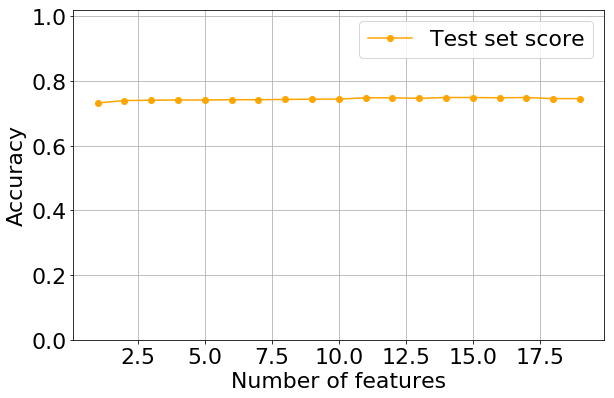

1 feature(s): [1]  Metric Score: 1545.2929290140535  Test Score: 0.7319762510602206
2 feature(s): [1, 5]  Metric Score: 1572.28708252718  Test Score: 0.73960983884648
3 feature(s): [1, 2, 5]  Metric Score: 1569.0613198300914  Test Score: 0.7404580152671756
4 feature(s): [1, 2, 5, 15]  Metric Score: 1565.8481485112725  Test Score: 0.741306191687871
5 feature(s): [1, 2, 5, 6, 15]  Metric Score: 1558.775726610735  Test Score: 0.741306191687871
6 feature(s): [1, 2, 5, 6, 9, 15]  Metric Score: 1555.5752293724008  Test Score: 0.7421543681085666
7 feature(s): [1, 2, 5, 6, 9, 10, 15]  Metric Score: 1548.5028074718634  Test Score: 0.7421543681085666
8 feature(s): [1, 2, 5, 6, 9, 10, 14, 15]  Metric Score: 1545.3150678337151  Test Score: 0.7430025445292621
9 feature(s): [1, 2, 5, 6, 9, 10, 13, 14, 15]  Metric Score: 1542.1401701437528  Test Score: 0.7438507209499576
10 feature(s): [1, 2, 5, 6, 9, 10, 11, 13, 14, 15]  Metric Score: 1535.0677482432154  Test Score: 0.7438507209499576
11 feature(s):

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
team_pred_model = LogisticRegression(penalty='l1', C=0.5, solver = 'saga', multi_class='ovr', n_jobs=-1, max_iter = 80000, random_state=20191028)
sfs = SFS(team_pred_model, k_features=X.shape[1], metric = 'bic', cv = 3)
sfs.fit(X_train_std, y_train)
plotSFS(sfs)
with open('pickle_models/sfs_player_goals_bic_logreg.pickle', 'wb') as handle:
    pickle.dump(sfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

i_max = np.argmax(sfs.test_scores_)
f = sfs.subsets_[i_max]
print(len(f))
team_pred_model = LogisticRegression(penalty='l1', C=0.5, solver = 'saga', multi_class='ovr', n_jobs=-1, max_iter = 80000, random_state=20191028)
team_pred_model.fit(X_train_std[:, f], y_train)
cv_scores = cross_val_score(team_pred_model, X_train_std[:, f], y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_std[:, f], y_train))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_std[:, f], y_test))

16 0.7449605217922499


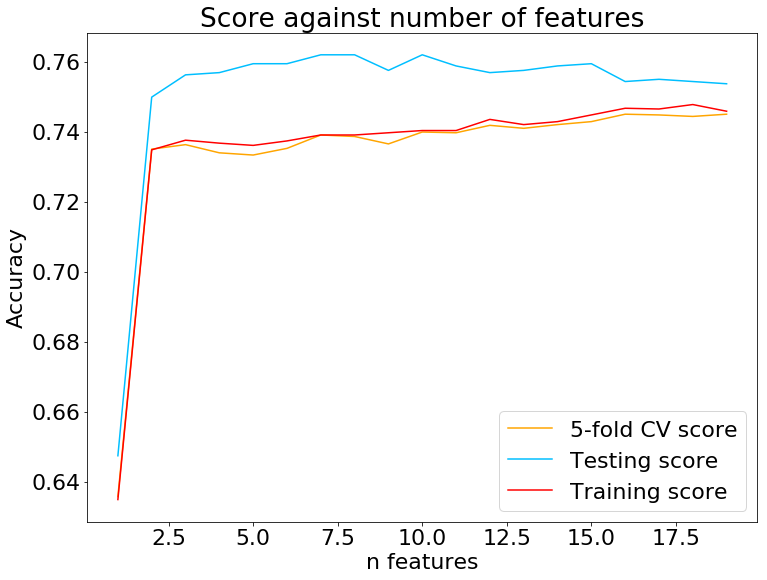

CV SCORES: [0.77330508 0.73940678 0.73940678 0.72033898 0.73516949 0.74152542
 0.73673036 0.74255319 0.77021277 0.73404255]
TRAINING Accuracy: 0.747
Average 10-Fold Training CV Score: 0.7432691413945363
TEST Accuracy: 0.754


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
tmp_model = LogisticRegression(penalty='l1', C=0.5, solver = 'saga', multi_class='ovr', n_jobs=-1, max_iter = 80000, random_state=20191028)
bestK = cvKBestSelector(X, y, tmp_model, StandardScaler())

X_ked = kBestSelector(X, y, score_func = chi2, k = bestK)
X_train_ked, X_test_ked, y_train_ked, y_test_ked = train_test_split(X_ked, y, test_size=0.25, random_state=20191027)
scaler = StandardScaler()
X_train_scled = scaler.fit_transform(X_train_ked.values)
X_test_scled = scaler.transform(X_test_ked.values)

team_pred_model = LogisticRegression(penalty='l1', C=0.5, solver = 'saga', multi_class='ovr', n_jobs=-1, max_iter = 80000, random_state=20191028)
team_pred_model.fit(X_train_scled, y_train_ked)
cv_scores = cross_val_score(team_pred_model, X_train_scled, y_train_ked, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_scled, y_train_ked))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_scled, y_test_ked))

19 0.7451714856084675


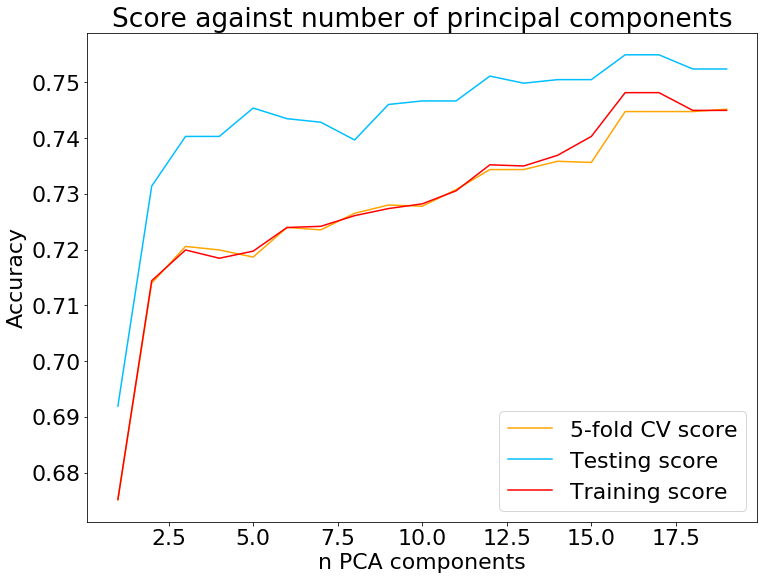

CV SCORES: [0.7690678  0.74364407 0.74152542 0.72245763 0.73728814 0.74364407
 0.75159236 0.74468085 0.76808511 0.72978723]
Average 10-Fold Training CV Score: 0.7451772666821327
Accuracy: 0.752


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
tmp_model = LogisticRegression(penalty='l1', C=0.5, solver = 'saga', multi_class='ovr', n_jobs=-1, max_iter = 80000, random_state=20191028)
bestK = cvPCA(X, y, tmp_model)
pca = PCA(n_components = bestK)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
rfc = LogisticRegression(penalty='l1', C=0.5, solver = 'saga', multi_class='ovr', n_jobs=-1, max_iter = 80000, random_state=20191028)
rfc.fit(X_train_pca, y_train)
cv_scores = cross_val_score(rfc, X_train_pca, y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % rfc.score(X_test_pca, y_test))

In [86]:
# log_reg = LogisticRegression(penalty='l2', C=0.001, solver = 'lbfgs', multi_class='ovr', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
# log_reg.fit(X_train, y_train)
# cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
# print("CV SCORES:", cv_scores)
# print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
# print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
# print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

In [87]:
# log_reg = LogisticRegression(penalty='l1', C=0.1, solver = 'liblinear', multi_class='ovr', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
# log_reg.fit(X_train, y_train)
# cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
# print("CV SCORES:", cv_scores)
# print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
# print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
# print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

In [88]:
# log_reg = LogisticRegression(penalty='l2', C=0.1, solver = 'liblinear', multi_class='ovr', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
# log_reg.fit(X_train, y_train)
# cv_scores = cross_val_score(log_reg, X_train, y_train, cv=8, n_jobs=-1)
# print("CV SCORES:", cv_scores)
# print('TRAINING Accuracy: %.3f' % log_reg.score(X_train, y_train))
# print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
# print('TEST Accuracy: %.3f' % log_reg.score(X_test, y_test))

In [89]:
# log_reg = LogisticRegression(penalty='l1', C=0.1, solver = 'saga', multi_class='ovr', verbose = 1, n_jobs=-1, max_iter = 80000, random_state=20191028)
# log_reg.fit(X_train_std, y_train)
# cv_scores = cross_val_score(log_reg, X_train_std, y_train, cv=15, n_jobs=-1)
# print("CV SCORES:", cv_scores)
# print('TRAINING Accuracy: %.3f' % log_reg.score(X_train_std, y_train))
# print("Average 8-Fold Training CV Score: {}".format(np.mean(cv_scores)))
# print('TEST Accuracy: %.3f' % log_reg.score(X_test_std, y_test))

In [90]:
# with open('pickle_models/scoring_prob_model.pickle', 'wb') as handle:
#     pickle.dump(log_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [91]:
# with open('pickle_models/scoring_prob_model_stdsc.pickle', 'wb') as handle:
#     pickle.dump(stdsc, handle, protocol=pickle.HIGHEST_PROTOCOL)

## RFC

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
estimator = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
selector = RFECV(estimator, step=1, cv=5, verbose = 0)
selector = selector.fit(X_train.values, y_train)
with open('pickle_models/rfecv_player_goals_rfc.pickle', 'wb') as handle:
    pickle.dump(selector, handle, protocol=pickle.HIGHEST_PROTOCOL)
f = selector.support_
print(sum(selector.support_))
team_pred_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
team_pred_model.fit(X_train.values[:, f], y_train)
cv_scores = cross_val_score(team_pred_model, X_train.values[:, f], y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train.values[:, f], y_train))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test.values[:, f], y_test))

9
CV SCORES: [0.78601695 0.76483051 0.73516949 0.72669492 0.74152542 0.75847458
 0.71974522 0.76382979 0.77234043 0.73829787]
TRAINING Accuracy: 0.766
Average 10-Fold Training CV Score: 0.75069251724431
TEST Accuracy: 0.764


Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9
Processing: 10
Processing: 11
Processing: 12
Processing: 13
Processing: 14
Processing: 15
Processing: 16
Processing: 17
Processing: 18


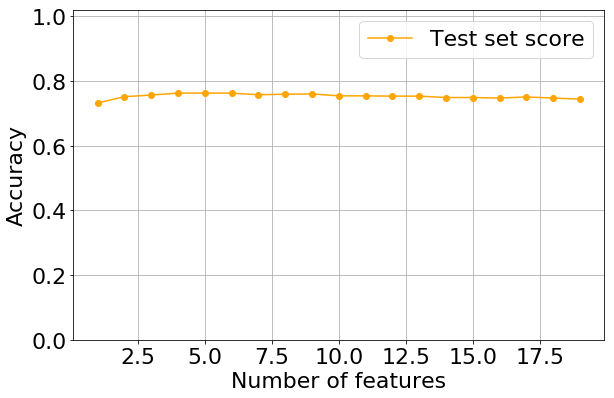

1 feature(s): [1]  Metric Score: 1545.2929290140535  Test Score: 0.7319762510602206
2 feature(s): [1, 4]  Metric Score: 1627.317070901363  Test Score: 0.7514843087362172
3 feature(s): [0, 1, 4]  Metric Score: 1644.6386226513548  Test Score: 0.7565733672603902
4 feature(s): [0, 1, 4, 5]  Metric Score: 1666.6787909948655  Test Score: 0.7625106022052587
5 feature(s): [0, 1, 4, 5, 6]  Metric Score: 1659.606369094328  Test Score: 0.7625106022052587
6 feature(s): [0, 1, 4, 5, 6, 11]  Metric Score: 1652.533947193791  Test Score: 0.7625106022052587
7 feature(s): [0, 1, 4, 5, 6, 10, 11]  Metric Score: 1620.4641224731927  Test Score: 0.7574215436810857
8 feature(s): [0, 1, 4, 5, 6, 10, 11, 12]  Metric Score: 1621.6654187371996  Test Score: 0.7591178965224766
9 feature(s): [0, 1, 4, 5, 6, 10, 11, 12, 17]  Metric Score: 1618.7517313073467  Test Score: 0.7599660729431722
10 feature(s): [0, 1, 4, 5, 6, 10, 11, 12, 15, 17]  Metric Score: 1582.8715935341538  Test Score: 0.7540288379983037
11 feature(s

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
team_pred_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
sfs = SFS(team_pred_model, k_features=X.shape[1], metric = 'bic', cv = 3)
sfs.fit(X_train.values, y_train)
plotSFS(sfs)
with open('pickle_models/sfs_player_goals_bic_rfc.pickle', 'wb') as handle:
    pickle.dump(sfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

i_max = np.argmax(sfs.test_scores_)
f = sfs.subsets_[i_max]
print(len(f))
team_pred_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
team_pred_model.fit(X_train.values[:, f], y_train)
cv_scores = cross_val_score(team_pred_model, X_train.values[:, f], y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train.values[:, f], y_train))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test.values[:, f], y_test))

4 0.7621415520770117


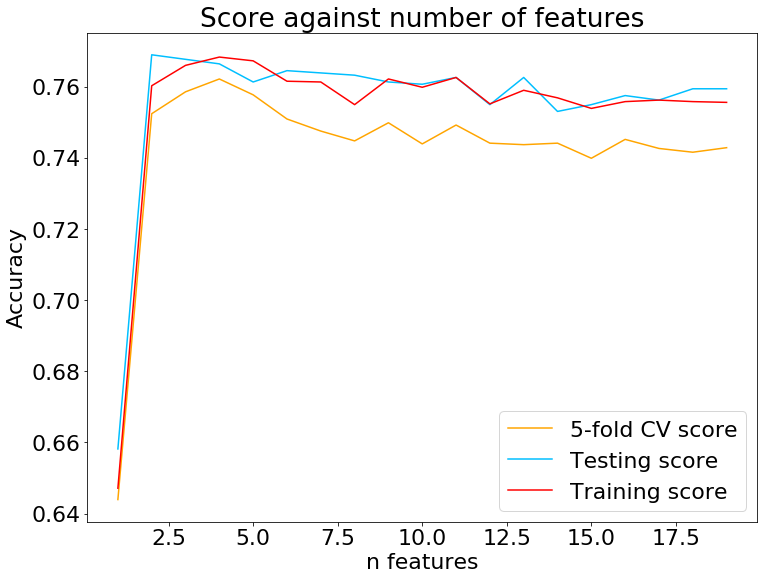

CV SCORES: [0.80084746 0.75847458 0.75       0.73305085 0.75211864 0.76271186
 0.74522293 0.76170213 0.75531915 0.76595745]
TRAINING Accuracy: 0.768
Average 10-Fold Training CV Score: 0.7585405043171068
TEST Accuracy: 0.766


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
tmp_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
bestK = cvKBestSelector(X, y, tmp_model)

X_ked = kBestSelector(X, y, score_func = chi2, k = bestK)
X_train_ked, X_test_ked, y_train_ked, y_test_ked = train_test_split(X_ked, y, test_size=0.25, random_state=20191027)

team_pred_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
team_pred_model.fit(X_train_ked, y_train_ked)
cv_scores = cross_val_score(team_pred_model, X_train_ked, y_train_ked, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_ked, y_train_ked))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_ked, y_test_ked))

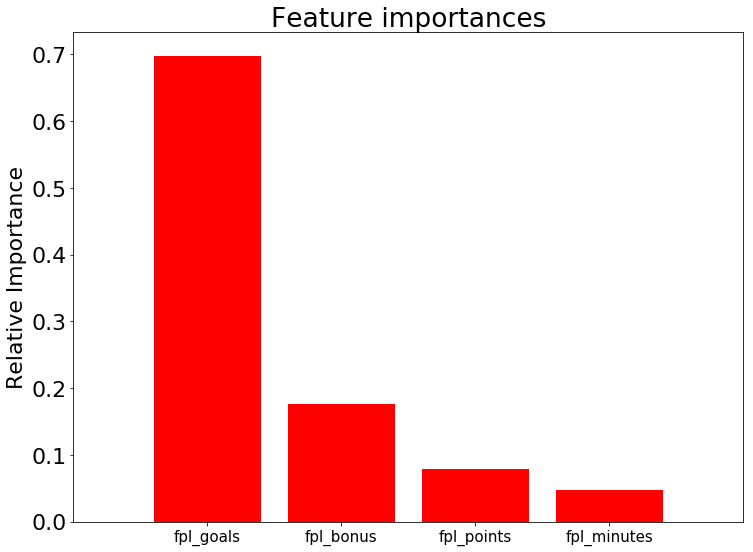

CV SCORES: [0.80084746 0.75847458 0.75       0.73305085 0.75211864 0.76271186
 0.74522293 0.76170213 0.75531915 0.76595745]
TRAINING Accuracy: 0.768
Average 10-Fold Training CV Score: 0.7585405043171068
TEST Accuracy: 0.766


In [32]:
X_ked = kBestSelector(X, y, score_func = chi2, k = 4 )
X_train_ked, X_test_ked, y_train_ked, y_test_ked = train_test_split(X_ked, y, test_size=0.25, random_state=20191027)

team_pred_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
team_pred_model.fit(X_train_ked, y_train_ked)
rfFeaturePlot(team_pred_model, X_ked.columns, title="Feature importances")
cv_scores = cross_val_score(team_pred_model, X_train_ked, y_train_ked, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_ked, y_train_ked))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_ked, y_test_ked))

15 0.7203511963563327


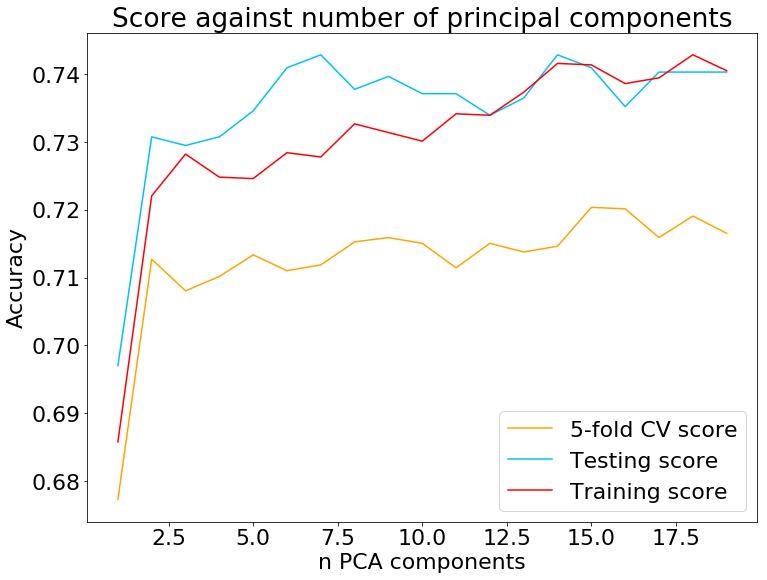

CV SCORES: [0.72457627 0.72457627 0.71398305 0.68855932 0.71398305 0.74576271
 0.6985138  0.72765957 0.74468085 0.72765957]
Average 10-Fold Training CV Score: 0.720995447839073
Accuracy: 0.741


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
tmp_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
bestK = cvPCA(X, y, tmp_model)
pca = PCA(n_components = bestK)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
rfc.fit(X_train_pca, y_train)
cv_scores = cross_val_score(rfc, X_train_pca, y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % rfc.score(X_test_pca, y_test))

In [97]:
# rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 4, random_state=20191027)
# rfc.fit(X_train, y_train)
# cv_scores = cross_val_score(rfc, X_train, y_train, cv=10, n_jobs=-1)
# print("CV SCORES:", cv_scores)
# print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
# print('Accuracy: %.3f' % rfc.score(X_test, y_test))

## SVC

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
estimator = SVC(C=0.05, kernel = 'linear', max_iter = 50000000, random_state = 20191028)
selector = RFECV(estimator, step=1, cv=5, verbose = 0)
selector = selector.fit(X_train_std, y_train)
with open('pickle_models/rfecv_player_goals_svc.pickle', 'wb') as handle:
    pickle.dump(selector, handle, protocol=pickle.HIGHEST_PROTOCOL)
f = selector.support_
print(sum(selector.support_))
team_pred_model = SVC(C=0.05, kernel = 'linear', max_iter = 50000000, random_state = 20191028)
team_pred_model.fit(X_train_std[:, f], y_train)
cv_scores = cross_val_score(team_pred_model, X_train_std[:, f], y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_std[:, f], y_train))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_std[:, f], y_test))

17
CV SCORES: [0.75423729 0.74576271 0.7309322  0.72245763 0.72245763 0.74364407
 0.73673036 0.75531915 0.76595745 0.73191489]
TRAINING Accuracy: 0.741
Average 10-Fold Training CV Score: 0.7409413375719613
TEST Accuracy: 0.757


Processing: 0
Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9
Processing: 10
Processing: 11
Processing: 12
Processing: 13
Processing: 14
Processing: 15
Processing: 16
Processing: 17
Processing: 18


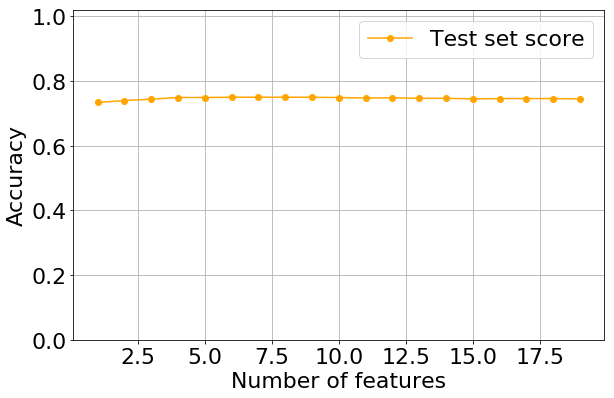

1 feature(s): [1]  Metric Score: 1552.7786684471923  Test Score: 0.7336726039016115
2 feature(s): [0, 1]  Metric Score: 1572.28708252718  Test Score: 0.73960983884648
3 feature(s): [0, 1, 3]  Metric Score: 1584.574701546977  Test Score: 0.7438507209499576
4 feature(s): [0, 1, 3, 16]  Metric Score: 1601.1619364833434  Test Score: 0.7489397794741306
5 feature(s): [0, 1, 3, 8, 16]  Metric Score: 1594.089514582806  Test Score: 0.7489397794741306
6 feature(s): [0, 1, 3, 7, 8, 16]  Metric Score: 1591.0069442056886  Test Score: 0.7497879558948262
7 feature(s): [0, 1, 3, 7, 8, 10, 16]  Metric Score: 1583.9345223051512  Test Score: 0.7497879558948262
8 feature(s): [0, 1, 3, 7, 8, 9, 10, 16]  Metric Score: 1576.8621004046138  Test Score: 0.7497879558948262
9 feature(s): [0, 1, 3, 7, 8, 9, 10, 13, 16]  Metric Score: 1569.7896785040764  Test Score: 0.7497879558948262
10 feature(s): [0, 1, 3, 7, 8, 9, 10, 13, 14, 16]  Metric Score: 1558.7274050801193  Test Score: 0.7489397794741306
11 feature(s): [

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
team_pred_model = SVC(C=0.05, kernel = 'linear', max_iter = 50000000, random_state = 20191028)
sfs = SFS(team_pred_model, k_features=X.shape[1], metric = 'bic', cv = 3)
sfs.fit(X_train_std, y_train)
plotSFS(sfs)
with open('pickle_models/sfs_player_goals_bic_svc.pickle', 'wb') as handle:
    pickle.dump(sfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

i_max = np.argmax(sfs.test_scores_)
f = sfs.subsets_[i_max]
print(len(f))
team_pred_model = SVC(C=0.05, kernel = 'linear', max_iter = 50000000, random_state = 20191028)
team_pred_model.fit(X_train_std[:, f], y_train)
cv_scores = cross_val_score(team_pred_model, X_train_std[:, f], y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_std[:, f], y_train))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_std[:, f], y_test))

17 0.7419912728004439


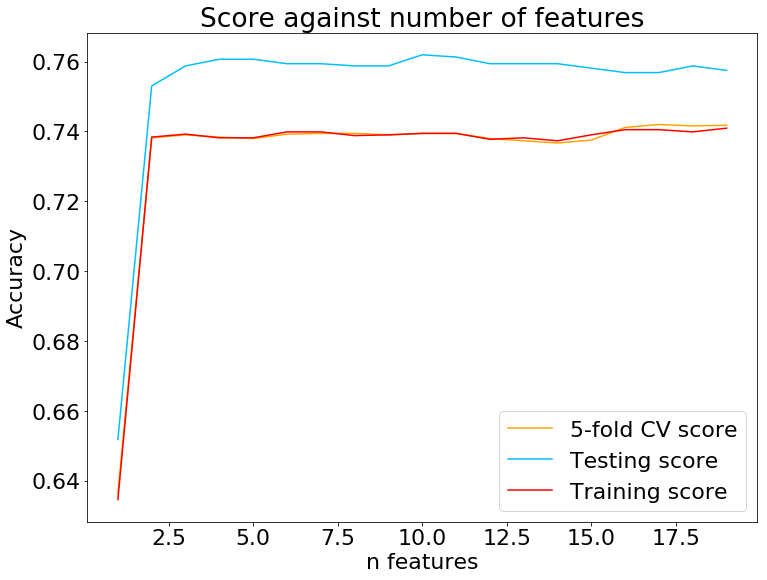

CV SCORES: [0.75635593 0.74788136 0.73305085 0.72245763 0.71822034 0.74576271
 0.73673036 0.75319149 0.76808511 0.73191489]
TRAINING Accuracy: 0.741
Average 10-Fold Training CV Score: 0.7413650663855206
TEST Accuracy: 0.757


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
tmp_model = SVC(C=0.05, kernel = 'linear', max_iter = 50000000, random_state = 20191028)
bestK = cvKBestSelector(X, y, tmp_model, StandardScaler())

X_ked = kBestSelector(X, y, score_func = chi2, k = bestK)
X_train_ked, X_test_ked, y_train_ked, y_test_ked = train_test_split(X_ked, y, test_size=0.25, random_state=20191027)
scaler = StandardScaler()
X_train_scled = scaler.fit_transform(X_train_ked.values)
X_test_scled = scaler.transform(X_test_ked.values)

team_pred_model = SVC(C=0.05, kernel = 'linear', max_iter = 50000000, random_state = 20191028)
team_pred_model.fit(X_train_scled, y_train_ked)
cv_scores = cross_val_score(team_pred_model, X_train_scled, y_train_ked, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print('TRAINING Accuracy: %.3f' % team_pred_model.score(X_train_scled, y_train_ked))
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('TEST Accuracy: %.3f' % team_pred_model.score(X_test_scled, y_test_ked))

19 0.7417791832460237


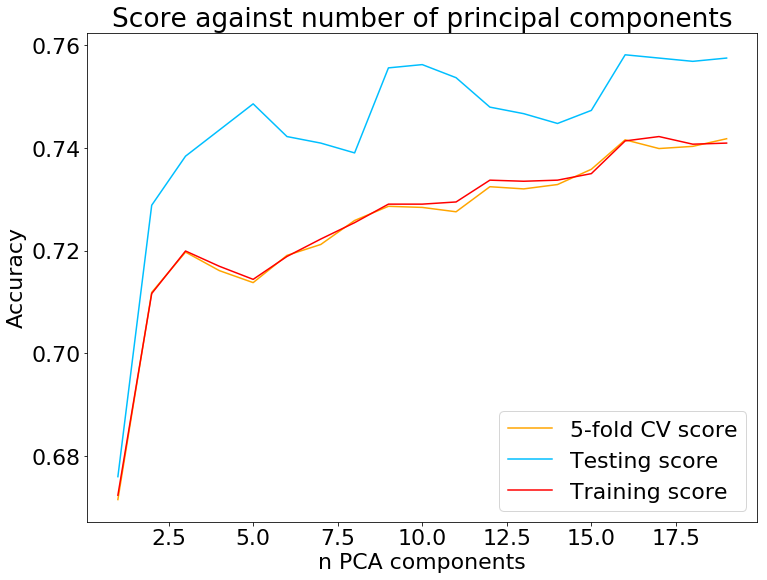

CV SCORES: [0.75423729 0.74364407 0.73305085 0.72245763 0.72245763 0.74576271
 0.74097665 0.75531915 0.76595745 0.73191489]
Average 10-Fold Training CV Score: 0.7415778304288471
Accuracy: 0.757


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20191027)
tmp_model = SVC(C=0.05, kernel = 'linear', max_iter = 50000000, random_state = 20191028)
bestK = cvPCA(X, y, tmp_model)
pca = PCA(n_components = bestK)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
rfc = SVC(C=0.05, kernel = 'linear', max_iter = 50000000, random_state = 20191028)
rfc.fit(X_train_pca, y_train)
cv_scores = cross_val_score(rfc, X_train_pca, y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % rfc.score(X_test_pca, y_test))

In [112]:
svc = SVC(C=0.05, kernel = 'linear',  max_iter = 50000000, random_state = 20191028)
svc.fit(X_train_std, y_train)
cv_scores = cross_val_score(svc, X_train_std, y_train, cv=10, n_jobs=-1)
print("CV SCORES:", cv_scores)
print("Average 10-Fold Training CV Score: {}".format(np.mean(cv_scores)))
print('Accuracy: %.3f' % svc.score(X_test_std, y_test))

[LibSVM]CV SCORES: [0.75423729 0.74576271 0.73305085 0.72457627 0.71822034 0.74364407
 0.74097665 0.75531915 0.76595745 0.73404255]
Average 10-Fold Training CV Score: 0.7415787319795143
Accuracy: 0.757
